<a href="https://colab.research.google.com/github/andreaskuepfer/data-analysis-visualization-lecture/blob/main/Data_Analysis_Guest_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Analysis: From Data Crawling to Visualization
### An Introduction to APIs for Social Scientists and How To (not) Display Data

##### **Data Analysis Guest Lecture**
##### **National University of Kyiv-Mohyla Academy**
##### **March 15, 2023**

##### *Andreas Küpfer (Technical University of Darmstadt)*

Today, we want to work with the tweets of the President of Ukraine: Volodymyr Zelenskyy.

This hands-on notebook is divided into four sections:

1. First, we will load our dataset into R and do some data wrangling before we add a sentiment score to each tweet.
2. Second, we are going to visualize the preprocessed data in R.
3. Third, we discuss further steps that could be applied to improve our analysis.
4. Last but not least you can find some resources if you decided to learn R to analyze your own data.

### But wait... How do I actually work in such a notebook and why do we need this?

In [ ]:
# I'm a comment and I'm always ignored by R
variable <- 1 + 2
print(variable)

[1] 3


### Loading Packages (additional functionalities) in R

In [ ]:
install.packages("pacman")

pacman::p_load(tidyverse,
               emoji,
               tidytext,
               textdata)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘tokenizers’



tidytext installed



## Part I: Loading and organizing the Tweets

First, we load our tweets, take a look at them and set a few filters.

In [ ]:
tweets <- readRDS(url("https://github.com/andreaskuepfer/data-analysis-visualization-lecture/blob/main/data/tweets.Rds?raw=true")) # Read the so-called .Rds-file

tweets_en <- tweets %>%
  select(created_at, text, lang) %>% # Select several columns
  filter(lang == "en") # Filter the dataset to keep only English tweets

Step two involves the extraction of (flag) emojis from all tweets.

In [ ]:
tweets_en_emoji <- tweets_en %>% # Select filtered data set (English language)
  dplyr::mutate(emoji = emoji::emoji_extract_all(text)) %>% # Extract all emojis using emoji::emoji_extract_all()
  tidyr::unnest(emoji) %>% # Generate one row per found emoji (e.g. 3 rows if a tweet contains 3 emojis)
  dplyr::mutate(emojiname = purrr::map(emoji, ~names(which(emoji::emoji_name == .)))) %>% # Replace emoji with alternative text (e.g. Ukrainian flag becomes "Ukraine")
  dplyr::filter(stringr::str_detect(stringr::str_c(emojiname), ".*flag.*")) %>% # Remove all rows or found emojis that are not flags
  dplyr::mutate(emojiname = stringr::str_extract(emojiname, regex("flag_.*[^\")]")), # Extract uniform country code from alternative text
                emojiname = stringr::str_remove(emojiname, "flag_")) # Remove "flag_" prefix from text

Warning message:
“There was 1 warning in `dplyr::filter()`.
ℹ In argument: `stringr::str_detect(stringr::str_c(emojiname), ".*flag.*")`.
Caused by warning in `stri_c()`:
! argument is not an atomic vector; coercing”
Warning message:
“There was 1 warning in `dplyr::mutate()`.
ℹ In argument: `emojiname = stringr::str_extract(emojiname,
  regex("flag_.*[^\")]"))`.
Caused by warning in `stri_extract_first_regex()`:
! argument is not an atomic vector; coercing”


In [ ]:
View(tweets_en_emoji) # Take a look at the dataset

created_at,text,lang,emoji,emojiname
<chr>,<chr>,<chr>,<chr>,<chr>
2023-01-12T16:35:56.000Z,"Had a fruitful conversation with 🇰🇪 President @WilliamsRuto. Thanked for constructive cooperation in the UN, for support as a 🇺🇳 Security Council member. Discussed #GrainfromUkraine initiative, food security and creation of grain hubs in Africa. Agreed to enhance cooperation!",en,🇰🇪,Kenya
2023-01-12T16:35:56.000Z,"Had a fruitful conversation with 🇰🇪 President @WilliamsRuto. Thanked for constructive cooperation in the UN, for support as a 🇺🇳 Security Council member. Discussed #GrainfromUkraine initiative, food security and creation of grain hubs in Africa. Agreed to enhance cooperation!",en,🇺🇳,United_Nations
2023-01-11T10:52:58.000Z,"I addressed the participants of the 80th @goldenglobes Awards. This award was born at a special time. WWII was not over yet, but the tide was turned – all knew who would win. It is now 2023. The war in 🇺🇦 is not over yet but the tide is turning &amp; it is already clear who will win. https://t.co/u7pHr0u0lq",en,🇺🇦,Ukraine
2023-01-10T14:58:23.000Z,I had a phone call with 🇧🇪 Prime Minister @alexanderdecroo. We discussed the current defense needs of Ukraine given possible escalation at the front. I invited Belgium to join the implementation of our 10-step #PeaceFormula. I also thanked for sheltering Ukrainian citizens.,en,🇧🇪,Belgium
2023-01-10T14:01:39.000Z,During a phone call with President of the European Council @CharlesMichel I informed him about the situation on the battlefield and 🇺🇦's current needs in armaments. We agreed on joint efforts to implement the #PeaceFormula &amp; discussed expectations from the upcoming 🇪🇺-🇺🇦 Summit.,en,🇺🇦,Ukraine
2023-01-10T14:01:39.000Z,During a phone call with President of the European Council @CharlesMichel I informed him about the situation on the battlefield and 🇺🇦's current needs in armaments. We agreed on joint efforts to implement the #PeaceFormula &amp; discussed expectations from the upcoming 🇪🇺-🇺🇦 Summit.,en,🇪🇺,European_Union
2023-01-10T14:01:39.000Z,During a phone call with President of the European Council @CharlesMichel I informed him about the situation on the battlefield and 🇺🇦's current needs in armaments. We agreed on joint efforts to implement the #PeaceFormula &amp; discussed expectations from the upcoming 🇪🇺-🇺🇦 Summit.,en,🇺🇦,Ukraine
2023-01-09T16:20:27.000Z,"Had a meaningful call with 🇨🇿 PM @P_Fiala. Thanked for supporting 🇺🇦 during @EU2022_CZ. Informed about the situation at the front, the threat of escalation by RF. We appreciate important 🇨🇿 defense support &amp; expect its strengthening. Special attention was paid to 🇺🇦 #PeaceFormula",en,🇨🇿,Czechia
2023-01-09T16:20:27.000Z,"Had a meaningful call with 🇨🇿 PM @P_Fiala. Thanked for supporting 🇺🇦 during @EU2022_CZ. Informed about the situation at the front, the threat of escalation by RF. We appreciate important 🇨🇿 defense support &amp; expect its strengthening. Special attention was paid to 🇺🇦 #PeaceFormula",en,🇺🇦,Ukraine


As we now have the flags we can take a look at the sentiment of each tweet. We can do this for example by using a simple dictionary approach:

In [ ]:
#afinn_dict <- tidytext::get_sentiments(lexicon = "afinn") # Load the sentiment (normally from tidytext Package)
afinn_dict <- readRDS(url("https://github.com/andreaskuepfer/data-analysis-visualization-lecture/blob/main/data/sentiment_afinn.Rds?raw=true")) # Load the sentiment directly from a file (as Google Colab does not support this kind of function)

afinn_dict %>%
  dplyr::group_by(value) %>% # Group the sentiment by their indicator values 
  dplyr::slice_sample(n=1) # Load a random sample per indicator category

word,value
<chr>,<dbl>
bastards,-5
fucked,-4
fiasco,-3
fatiguing,-2
curse,-1
some kind,0
advanced,1
yeees,2
beautifully,3


To combine our sentiment dictionary with the each tweet some data wrangling is need which is described in the following code chunks in a step-by-step manner:

In [ ]:
tweets_en_emoji_sentiment <- tweets_en_emoji %>%
  dplyr::select(emojiname, text) # Select several columns

head(tweets_en_emoji_sentiment) # Take a look at the first few rows of the dataframe

emojiname,text
<chr>,<chr>
Kenya,"Had a fruitful conversation with 🇰🇪 President @WilliamsRuto. Thanked for constructive cooperation in the UN, for support as a 🇺🇳 Security Council member. Discussed #GrainfromUkraine initiative, food security and creation of grain hubs in Africa. Agreed to enhance cooperation!"
United_Nations,"Had a fruitful conversation with 🇰🇪 President @WilliamsRuto. Thanked for constructive cooperation in the UN, for support as a 🇺🇳 Security Council member. Discussed #GrainfromUkraine initiative, food security and creation of grain hubs in Africa. Agreed to enhance cooperation!"
Ukraine,"I addressed the participants of the 80th @goldenglobes Awards. This award was born at a special time. WWII was not over yet, but the tide was turned – all knew who would win. It is now 2023. The war in 🇺🇦 is not over yet but the tide is turning &amp; it is already clear who will win. https://t.co/u7pHr0u0lq"
Belgium,I had a phone call with 🇧🇪 Prime Minister @alexanderdecroo. We discussed the current defense needs of Ukraine given possible escalation at the front. I invited Belgium to join the implementation of our 10-step #PeaceFormula. I also thanked for sheltering Ukrainian citizens.
Ukraine,During a phone call with President of the European Council @CharlesMichel I informed him about the situation on the battlefield and 🇺🇦's current needs in armaments. We agreed on joint efforts to implement the #PeaceFormula &amp; discussed expectations from the upcoming 🇪🇺-🇺🇦 Summit.
European_Union,During a phone call with President of the European Council @CharlesMichel I informed him about the situation on the battlefield and 🇺🇦's current needs in armaments. We agreed on joint efforts to implement the #PeaceFormula &amp; discussed expectations from the upcoming 🇪🇺-🇺🇦 Summit.


In [ ]:
tweets_en_emoji_sentiment <- tweets_en_emoji %>%
  dplyr::select(emojiname, text) %>% # Select several columns
  tidytext::unnest_tokens(output = word, input = text) # Unnest the tokens so that each token gets its own row

head(tweets_en_emoji_sentiment) # Take a look at the first few rows of the dataframe

emojiname,word
<chr>,<chr>
Kenya,had
Kenya,a
Kenya,fruitful
Kenya,conversation
Kenya,with
Kenya,president


In [ ]:
tweets_en_emoji_sentiment <- tweets_en_emoji %>%
  dplyr::select(emojiname, text) %>% # Select several columns
  tidytext::unnest_tokens(output = "word", input = text) %>% # Unnest the tokens so that each token gets its own row
  dplyr::right_join(y = afinn_dict, by = "word") %>% # Join the sentiment dictionary to our words
  dplyr::filter(!is.na(emojiname)) # Remove words without assigned sentiment from our dataframe

head(tweets_en_emoji_sentiment) # Take a look at the first few rows of the dataframe

emojiname,word,value
<chr>,<chr>,<dbl>
Kenya,support,2
Kenya,agreed,1
United_Nations,support,2
United_Nations,agreed,1
Ukraine,awards,3
Ukraine,award,3


In [ ]:
tweets_en_emoji_sentiment <- tweets_en_emoji %>%
  dplyr::select(emojiname, text) %>% # Select several columns
  tidytext::unnest_tokens(output = "word", input = text) %>% # Unnest the tokens so that each token gets its own row
  dplyr::right_join(y = afinn_dict, by = "word") %>% # Join the sentiment dictionary to our words
  dplyr::filter(!is.na(emojiname)) %>% # Remove words without assigned sentiment from our dataframe
  dplyr::count(emojiname, value, name = "count") # Count occurences of different sentiment scores per country

head(tweets_en_emoji_sentiment) # Take a look at the first few rows of the dataframe

emojiname,value,count
<chr>,<dbl>,<int>
Albania,-2,2
Albania,-1,5
Albania,2,11
Albania,3,3
Angola,1,1
Argentina,1,1


In [ ]:
tweets_en_emoji_sentiment <- tweets_en_emoji %>%
  dplyr::select(emojiname, text) %>% # Select several columns
  tidytext::unnest_tokens(output = "word", input = text) %>% # Unnest the tokens so that each token gets its own row
  dplyr::right_join(y = afinn_dict, by = "word") %>% # Join the sentiment dictionary to our words
  dplyr::filter(!is.na(emojiname)) %>% # Remove words without assigned sentiment from our dataframe
  dplyr::count(emojiname, value, name = "count") %>% # Count occurences of different sentiment scores per country
  dplyr::group_by(emojiname) %>% # Group the dataframe by country
  dplyr::mutate(n_normalized = count/sum(count) * 100) # Calculate the normalized ratio of sentiment scores

head(tweets_en_emoji_sentiment) # Take a look at the first few rows of the dataframe

emojiname,value,count,n_normalized
<chr>,<dbl>,<int>,<dbl>
Albania,-2,2,9.52381
Albania,-1,5,23.80952
Albania,2,11,52.38095
Albania,3,3,14.28571
Angola,1,1,100.00000
Argentina,1,1,33.33333


There we go! We loaded our tweets as well as the sentiment dictionary, extracted flag emojis from the tweets and combined both, the tweets and the sentiments.

## Part II: Visualizing the results

This chapter is all about visualizing our data which we previously prepared. First, we would like to take a look at just a selection of countries and their sentiment used in Zelenskyy's tweets (you can modify and play around with outher countries, just give it a try!):

In [ ]:
country_list <- c("Ukraine", "Germany", "Poland", "European_Union", "Belarus", "Russia", "United_States", "United_Kingdom", "Mozambique", "Canada")

To 

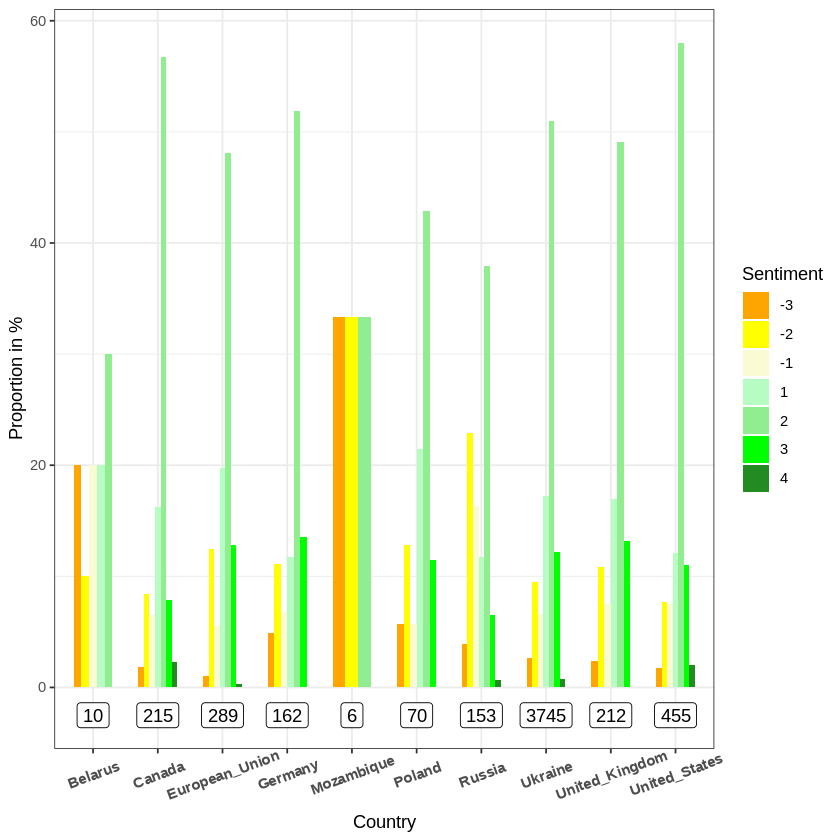

In [ ]:
# Count total number of tweets per country (labelling)
label_df <- tweets_en_emoji_sentiment %>%
  dplyr::filter(emojiname %in% country_list) %>% # Cilter on countries which we would like to take a look at
  dplyr::group_by(emojiname) %>% # Group by country
  dplyr::summarise(label = sum(count)) # Count all tweets per country

# Create a bar plot
ggplot2::ggplot(data = tweets_en_emoji_sentiment %>%
                  dplyr::filter(emojiname %in% country_list), # Filter on countries which we would like to take a look at
                mapping = ggplot2::aes(x = emojiname, y = n_normalized)) + # Select columns for x and y axis
  ggplot2::geom_col(aes(fill = as.factor(value)), position = ggplot2::position_dodge(.6), width=.6) + # Create the bars
  ggplot2::geom_label(aes(label = label, y = -2.5), data = label_df) + # Add our total number label
  ggplot2::scale_fill_manual(name = "Sentiment", # Set the title and colors for the legend and bars
                             values = c("-5" = "#8B0000",
                               "-4" = "#FF0000",
                               "-3" = "#FFA500",
                               "-2" = "#FFFF00",
                               "-1" = "#fafad4",
                               "0" = "#B0B0B0",
                               "1" = "#b6fcc3",
                               "2" = "#90EE90",
                               "3" = "#00FF00",
                               "4" = "#228B22",
                               "5" = "#006400")) +
  ggplot2::labs(x = "Country", # Set X axis label
                y = "Proportion in %") + # Set y axis label
  ggplot2::theme_bw() + # Set a black and white theme to improve contrast
  ggplot2::theme(axis.text.x = element_text(angle = 20, vjust = 0.7, face="bold")) # Rotate our x axis ticks

As we now got an overview of all tweets without focusing on the publishing date of them we dive deeper into this in the following code chunks: We take a look at tweets per the start of the war and after. We can reuse some of the code we developed earlier for this.

In [ ]:
# Create column to distinct between tweets before and after the start of the war
# Again add the sentiment to the tweets and group by the new column
tweets_en_emoji_sentiment_before <- tweets_en_emoji %>%
  dplyr::filter(emojiname %in% country_list) %>% # Filter on countries which we would like to take a look at
  dplyr::mutate(before_war = created_at < as.Date("2022-02-24")) %>% # Create a new column which describes whether a tweet was created before the war or after
  dplyr::select(before_war, emojiname, text) %>% # Select important columns
  tidytext::unnest_tokens(output = "word", input = text) %>% # Unnest the tokens so that each token gets its own row
  dplyr::right_join(y = afinn_dict, by = "word") %>% # Join the sentiment dictionary to our words
  dplyr::filter(!is.na(emojiname)) %>% # Remove words without assigned sentiment from our dataframe
  dplyr::count(before_war, emojiname, value, name = "count") %>% # Count occurences of different sentiment scores per country (before and after war)
  dplyr::group_by(emojiname, before_war) %>% # Group by country and before and after war start
  dplyr::mutate(n_normalized = count/sum(count) * 100) # Calculate the normalized ratio of sentiment scores

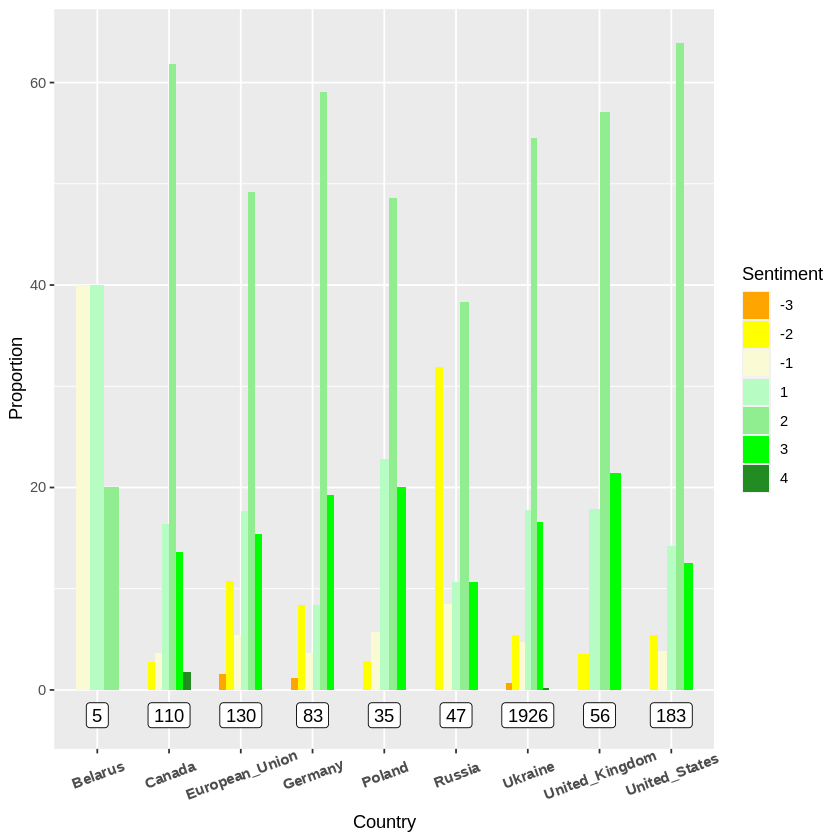

In [ ]:
# Before war start
label_df <- tweets_en_emoji_sentiment_before %>%
  dplyr::filter(before_war) %>%
  dplyr::group_by(emojiname) %>%
  dplyr::summarise(label = sum(count))

ggplot2::ggplot(tweets_en_emoji_sentiment_before %>%
                  dplyr::filter(before_war),
                mapping = ggplot2::aes(x = emojiname, y = n_normalized)) +
  ggplot2::geom_col(ggplot2::aes(fill = as.factor(value)), position=ggplot2::position_dodge(.6), width=.6) +
  ggplot2::geom_label(ggplot2::aes(label = label, y = -2.5), data = label_df) +
  ggplot2::scale_fill_manual(name = "Sentiment",
                             values = c("-5" = "#8B0000", # Color Gradient (HEX Codes) generated by ChatGPT
                               "-4" = "#FF0000",
                               "-3" = "#FFA500",
                               "-2" = "#FFFF00",
                               "-1" = "#fafad4",
                               "0" = "#B0B0B0",
                               "1" = "#b6fcc3",
                               "2" = "#90EE90",
                               "3" = "#00FF00",
                               "4" = "#228B22",
                               "5" = "#006400")) +
  ggplot2::labs(x = "Country",
                y = "Proportion") +
  ggplot2::theme(axis.text.x = element_text(angle = 20, vjust = 0.7, face="bold"))

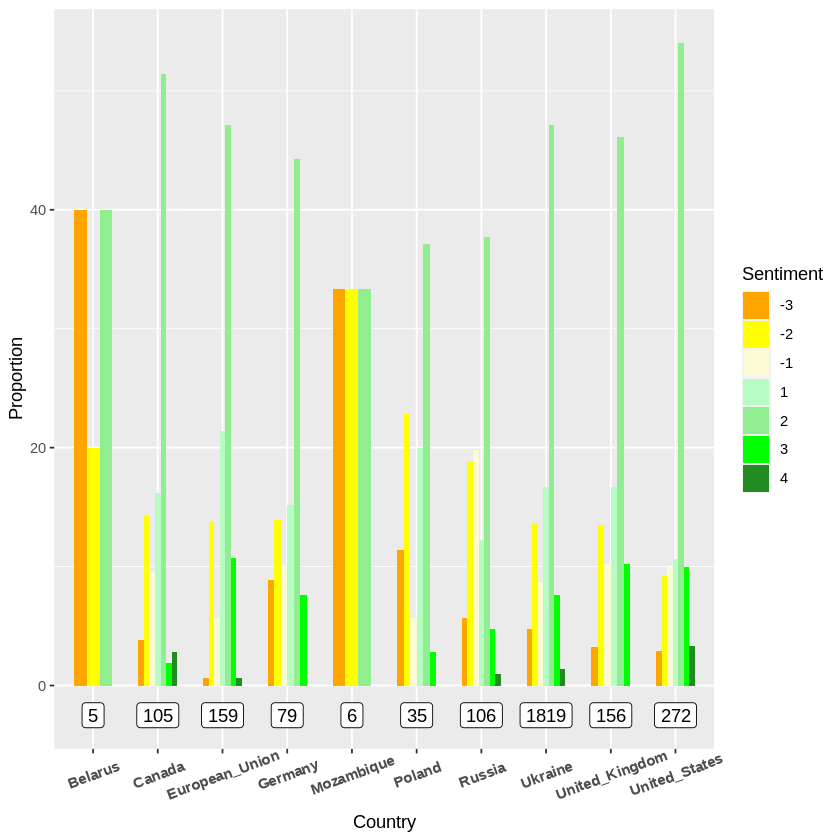

In [ ]:
# After Start of the War
label_df <- tweets_en_emoji_sentiment_before %>%
  dplyr::filter(!before_war) %>%
  dplyr::group_by(emojiname) %>%
  summarise(label = sum(count))

ggplot2::ggplot(tweets_en_emoji_sentiment_before %>%
                  dplyr::filter(!before_war),
                mapping = ggplot2::aes(x = emojiname, y = n_normalized)) +
  ggplot2::geom_col(ggplot2::aes(fill = as.factor(value)), position=ggplot2::position_dodge(.6), width=.6) +
  ggplot2::geom_label(ggplot2::aes(label = label, y = -2.5), data = label_df) +
  ggplot2::scale_fill_manual(name = "Sentiment",
                             values = c("-5" = "#8B0000",
                               "-4" = "#FF0000",
                               "-3" = "#FFA500",
                               "-2" = "#FFFF00",
                               "-1" = "#fafad4",
                               "0" = "#B0B0B0",
                               "1" = "#b6fcc3",
                               "2" = "#90EE90",
                               "3" = "#00FF00",
                               "4" = "#228B22",
                               "5" = "#006400"),
                             drop = FALSE) +
  ggplot2::labs(x = "Country",
                y = "Proportion") +
  ggplot2::theme(axis.text.x = element_text(angle = 20, vjust = 0.7, face="bold"))

### Alternative Way to Present the Data

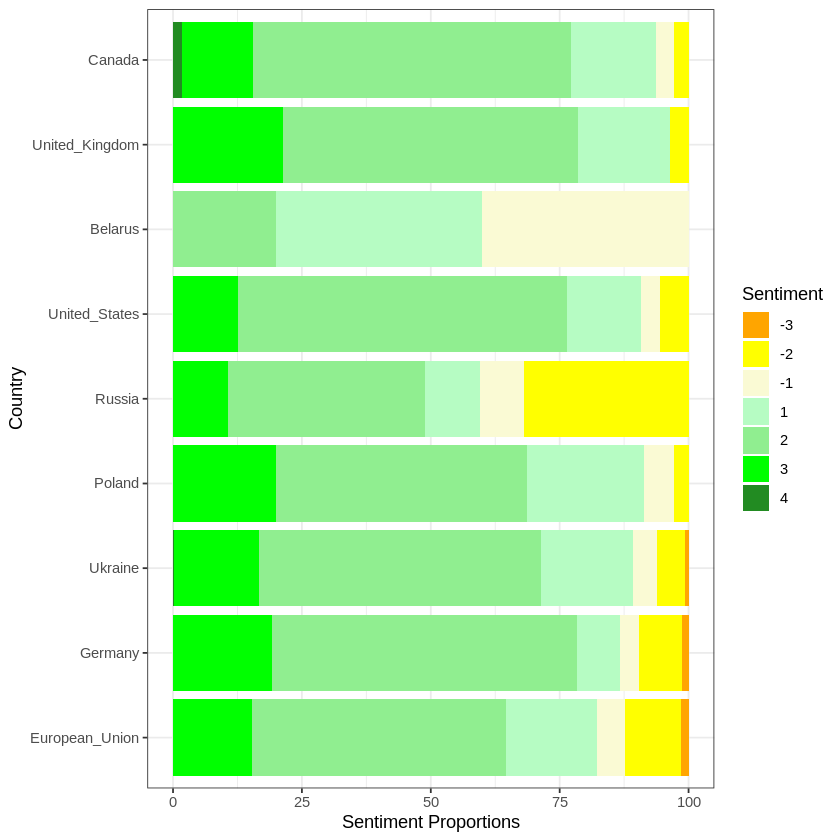

In [ ]:
ggplot2::ggplot(data = tweets_en_emoji_sentiment_before %>%
                  dplyr::filter(before_war) %>%
                  dplyr::group_by(emojiname) %>%
                  dplyr::mutate(mean = sum(value) / dplyr::n()) %>%
                  dplyr::arrange(desc(mean), .by_group = TRUE),
                mapping = ggplot2::aes(x = forcats::fct_reorder(as.factor(emojiname), mean),
                                       y = n_normalized)) +
  ggplot2::geom_col(aes(fill = as.factor(value))) +
  ggplot2::scale_fill_manual(name = "Sentiment",
                           values = c("-5" = "#8B0000",
                             "-4" = "#FF0000",
                             "-3" = "#FFA500",
                             "-2" = "#FFFF00",
                             "-1" = "#fafad4",
                             "0" = "#B0B0B0",
                             "1" = "#b6fcc3",
                             "2" = "#90EE90",
                             "3" = "#00FF00",
                             "4" = "#228B22",
                             "5" = "#006400"),
                           drop = FALSE) +
  ggplot2::coord_flip() +
  ggplot2::labs(y = "Sentiment Proportions",
                x = "Country") +
  ggplot2::theme_bw()

## Next Steps

What else? How could we proceed?

We could:
1. Also check the text for country names
2. Look for synonyms for the mentions of Russia
3. Apply more sophisticated models for sentiment extraction

What are your ideas?

## Resources to learn R (and beyond)

There are many learning offerings freely available on the web. Below you find some recommendations:



* DataQuest interactive tutorials: [Introduction to Data Analysis in R](https://www.dataquest.io/course/intro-to-r-rewrite/)
* [R for Data Science](https://r4ds.hadley.nz/) by Hadley Wickham and Garrett Grolemund (2022)
* [How to learn R?](https://ozlemtuncel.github.io/files/Learning_R.pdf) by Ozlem Tuncel (2022)
